In [36]:
import os
import cv2
import time
import argparse
import easydict
import numpy as np
from PIL import Image
from tqdm import tqdm
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import pretrainedmodels
# https://github.com/Cadene/pretrained-models.pytorch

from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Flip, Normalize, Resize

# Data

In [2]:
# Get a little bit data structure
# Must compile to get the global variables
classes = os.listdir('dataset')
classes.sort()
counts = [len(os.listdir(os.path.join('dataset', cls))) for cls in classes]
# we only deal with jpg format
paths = [os.path.join('dataset',cls,path) for cls in classes for path in os.listdir(os.path.join('dataset', cls)) if path.endswith('.jpg')]

cl1 = [path for path in paths if path.split('/')[1] == classes[0]]
cl2 = [path for path in paths if path.split('/')[1] == classes[1]]
cl3 = [path for path in paths if path.split('/')[1] == classes[2]]
cl4 = [path for path in paths if path.split('/')[1] == classes[3]]

print(f'There are {classes}: total {len(classes)} classes')
print(f'There are {[len(cl1), len(cl2), len(cl3), len(cl4)]} counts for each class')
print(f'Example data path:\n{paths[0]}')

There are ['manatees', 'seal', 'sealions', 'walrus']: total 4 classes
There are [921, 962, 965, 949] counts for each class
Example data path:
dataset/manatees/depositphotos_11395428-stock-photo-west-indian-manatee-breathing.jpg


In [3]:
# since some images somehow cannot open, i just kill them .@.
# which may take a while
# run one time only

# for path in paths:
#     image = cv2.imread(path, cv2.IMREAD_COLOR)
#     try:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     except:
#         print(path)
#         os.remove(path)

In [4]:
# Define your own dataset
# note that one must inherit `Dataset` class, in order to be used by Dataloader
# which is the distributer of data.
# There there are 3 attributes must implement: __init__, __len__, __getitem__

class AnimalDataset(Dataset):
    def __init__(self, mode='train', val_split=0.3, test_split=0.1, image_size=256, seed=42):
        assert mode in ['train','val','test']
        super().__init__()
        self.mode = mode
        self.image_size = image_size
        self.paths  = paths
        self.labels = [j for i, _ in enumerate(classes) for j in [i]*counts[i]]
        
        np.random.seed(seed)  # fix the seed for consistent train val test set
        rand_index = np.random.permutation([i for i in range(len(self.paths))])
        self.paths = [self.paths[i] for i in rand_index]
        self.labels= [self.labels[i] for i in rand_index]

        # split data here
        end_train_idx = round(len(self.paths)*(1-val_split-test_split))
        end_val_idx   = round(len(self.paths)*(1-test_split))
        if mode == 'train':
            self.paths = self.paths[:end_train_idx]
            self.labels= self.labels[:end_train_idx]
        elif mode == 'val':
            self.paths = self.paths[end_train_idx:end_val_idx]
            self.labels= self.labels[end_train_idx:end_val_idx]
        else:
            self.paths = self.paths[end_val_idx:]
            self.labels= self.labels[end_val_idx:]

    def __len__(self):
        return len(self.paths)
    
    def train_transfrom(self, image, image_size):
        # simple augmentation
        transform = Compose([
                            Resize(image_size,image_size, interpolation=cv2.INTER_AREA),
                            Flip(),
                            Normalize(mean =[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
                            ToTensorV2()
                            ])
        image_transform = transform(image = image)['image']
        return image_transform

    def val_transfrom(self, image, image_size):
        transform = Compose([
                            Resize(image_size,image_size, interpolation=cv2.INTER_AREA),
                            Normalize(mean =[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
                            ToTensorV2()
                            ])
        image_transform = transform(image = image)['image']
        return image_transform

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx])
        path  = self.paths[idx]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mode == 'train':
            image = self.train_transfrom(image, self.image_size)
        else:
            image = self.val_transfrom(image, self.image_size)

        return image, label


#  Model

In [5]:
# all model should inherit nn.Module
# the base model I choose resnet18

class AnimalModel(nn.Module):
    def __init__(self, hidden_dim=64, dropout=0.5, classes=4):
        super().__init__()
        self.base = pretrainedmodels.__dict__['resnet18'](num_classes=1000, pretrained='imagenet') # the pretrain model
        # get the dim of output feature map from base model
        dim_feats = self.base.last_linear.in_features 
        self.linear1 = nn.Linear(dim_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, classes)
        self.dropout = nn.Dropout(p=dropout)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.act = nn.ReLU()

    def features(self, input):
        return self.base.features(input)

    def logits(self, feature):
        output = self.pool(feature)
        output = output.view(output.size(0), -1)
        output = self.linear1(output)
        output = self.act(output)
        output = self.dropout(output)
        output = self.linear2(output)
        return output
    
    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


# Helper Function

In [6]:
def datasets(args):
    train_dataset = AnimalDataset(mode='train', image_size=args.image_size, val_split=args.val_split, 
                                test_split=args.test_split, seed=args.seed)
    val_dataset   = AnimalDataset(mode='val', image_size=args.image_size, 
                                val_split=args.val_split,test_split=args.test_split, seed=args.seed)
    test_dataset  = AnimalDataset(mode='test', image_size=args.image_size, 
                                val_split=args.val_split, test_split=args.test_split, seed=args.seed)

    train_loader = DataLoader(train_dataset, pin_memory=True, num_workers=os.cpu_count(),batch_size=args.batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, pin_memory=True, num_workers=2*os.cpu_count(), batch_size=args.batch_size, shuffle=True)
    test_loader   = DataLoader(test_dataset, pin_memory=True, num_workers=2*os.cpu_count(), batch_size=args.batch_size, shuffle=True)
    return train_loader, val_loader, test_loader

def check_args():
    assert args.optim in ['Adam','SGD'], 'chose optim not implement'
    assert args.lr_name in ['ReduceLROnPlateau'], 'I am lazy, choose ReduceLROnPlateau instead :>'

    print('\n---- Training parameters ----')
    print(f'image size: {args.image_size}')
    print(f'Optimizer : {args.optim}')
    print(f'Hidden dim: {args.hidden_dim}')
    print(f'Randomseed: {args.seed}')
    print(f'Initial lr: {args.lr}')
    print(f'lr name   : {args.lr_name}')
    print(f'Output cls: {args.classes}')
    print(f'Epoch     : {args.epoch}')
    print(f'Batch size: {args.batch_size}')

# Training & Validation

In [7]:
def train():
    check_args()
    # use GPU to do the training
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

    if not os.path.exists(os.path.join(os.getcwd(), 'runs')):
        os.mkdir(os.path.join(os.getcwd(), 'runs'))
    trial_num = os.listdir(os.path.join(os.getcwd(), 'runs'))
    if trial_num == []:
        exp_num = 0
    else:
        exp_num = [int(num.replace('trial_', '')) for num in trial_num]
        exp_num = max(exp_num) +1 
    print(f'\n== Trial {exp_num} begins ==\n')

    print('\n-------- Data Preparing --------\n')
    train_loader, val_loader, test_loader = datasets(args)
    print('-------- Data Preparing Done! --------')

    print('-------- Preparing Model --------')
    model = AnimalModel(hidden_dim=args.hidden_dim, dropout=args.dropout, classes=args.classes)
    # move model to GPU
    model = model.to(device)
    # loss
    criterion = nn.CrossEntropyLoss()
    if args.optim == 'Adam':
        # before acc 80 %
        optimizer = optim.Adam(model.parameters())
    elif args.optim == 'SGD':
        # after acc 80 %
        optimizer = optim.SGD(model.parameters(), momentum=args.momentum, lr=args.lr, nesterov=True, weight_decay=args.weight_decay)
    # lr scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience=6)
    print('-------- Preparing Model Done! --------')

    print('\n-------- Starting Training --------\n')
    # use Tensorbroad to record
    writer = SummaryWriter(f'runs/trial_{exp_num}')

    # comparsion of accuracy, only save the best weight
    accuracies = [0.]
    k = 0
    for epoch in range(args.epoch):
        start_time = time.time()
        train_running_loss = 0.0
        print(f'--- The {epoch+1}/{args.epoch} epoch ---')
        #  --------------------------- TRAINING LOOP ---------------------------
        print('\n--- Training Loop begins ---')
        print('[Epoch, Batch] : Loss')
        # set the optim to zero gradient
        optimizer.zero_grad()
        # set the model into training mode
        model.train()
        for i, data in enumerate(train_loader, start=0):
            # move data to GPU
            input, target = data[0].to(device), data[1].to(device)
            # foward
            output = model(input)
            loss = criterion(output, target)
            # backward
            loss.backward()
            train_running_loss += loss.item()
            # using the forward and backward info to update the parameters
            optimizer.step()
            # set the optim to zero gradient, in order to calculate new gradient in the next run
            # else will be accumlate (which also is the virture of Pytorch)
            optimizer.zero_grad()
            # record loss evey 50 iterations
            if (i+1)%50 == 0:
                    k += 1
                    writer.add_scalar('Batch-Averaged loss', train_running_loss, k)
                    print( f"[{epoch+1}, {i+1}]: %.3f" % train_running_loss)
                    train_running_loss = 0.0
        
        # record the lr use in the epoch
        lr = [group['lr'] for group in optimizer.param_groups]
        print('Epoch:', f'{epoch+1}/{args.epoch}',' LR:', lr[0])
        writer.add_scalar('Learning Rate', lr[0], epoch)
        print('--- Training Loop ends ---\n')
        print(f'--- Training spend time: %.1f sec ---' % (time.time() - start_time))

        #  --------------------------- VALIDATION LOOP ---------------------------
        # which ensure all the parameters are not calulcating gradients
        with torch.no_grad():
            # set the model into evalution mode, basically what torch.no_grad() does
            model.eval()
            val_run_loss = 0.0
            print('\n--- Validaion Loop begins ---')
            start_time = time.time()
            batch_count = 0
            total_count = 0
            correct_count = 0
            for data in tqdm(val_loader, desc='Validation'):
                input, target = data[0].to(device), data[1].to(device)
                output = model(input)
                _, predicted = torch.max(output, 1)
                loss = criterion(output, target)
                val_run_loss  += loss.item()
                correct_count += (predicted == target).sum().item()
                batch_count += 1
                total_count += target.size(0)
            accuracy = (100 * correct_count/total_count)
            val_run_loss = val_run_loss/batch_count

            if not os.path.exists(os.path.join(os.getcwd(), 'model_save')):
                os.mkdir(os.path.join(os.getcwd(), 'model_save'))
            if max(accuracies) < accuracy:
                savepath = os.path.join(os.getcwd(),'model_save',f'{exp_num}_best.pth')
                torch.save(model.state_dict(), savepath)
                print('\n-------- Saveing the best weight --------')
            else:
                print('\n-------- Accuracy is not improving --------')
            accuracies.append(accuracy)

            scheduler.step(val_run_loss)
            writer.add_scalar('Validation accuracy', accuracy, epoch)
            writer.add_scalar('Validation loss', val_run_loss, epoch)

            print(f"Loss of {epoch+1} epoch is {val_run_loss:.3f}")
            print(f"Accuracy is {accuracy:.2f} % \n")
            print('--- Validaion Loop ends ---\n')
            print(f'--- Validaion spend time: %.1f sec ---' % (time.time() - start_time))
    writer.close()
    print('\n-------- End Training --------\n')
    print(f'\n--- Best accuracy: {max(accuracies):.2f} % ---')
    print(f'\n== Trial {exp_num} finished ==\n')

In [8]:
# Arguments
args = easydict.EasyDict({
        # Basic
        'image_size': 256,
        'val_split':0.3,
        'test_split':0.1,
        'seed':42,
        # FC
        'hidden_dim':64,
        'dropout':0.5,
        # Additional Hyperparameter
        'classes':4,
        # Training Related
        'optim':'Adam',
        'momentum':0.9,
        'weight_decay':0.01,
        'lr':0.0001,
        'lr_name':'ReduceLROnPlateau',
        # Loop control
        'epoch':10,
        'batch_size': 128
        })

In [9]:
start_time = time.time()
train()
print('--- Total Execution time ---')
exe_time = (time.time() - start_time)
hr = int(exe_time // 3600)
min = int(((exe_time / 3600) - hr) * 60)
sec = ((((exe_time / 3600) - hr) * 60) - min)*60
print(f'--- {hr}:{min}:{sec:.1f} (hr:min:sec)---')


---- Training parameters ----
image size: 256
Optimizer : Adam
Hidden dim: 64
Randomseed: 42
Initial lr: 0.0001
lr name   : ReduceLROnPlateau
Output cls: 4
Epoch     : 10
Batch size: 128

== Trial 17 begins ==


-------- Data Preparing --------

-------- Data Preparing Done! --------
-------- Preparing Model --------
-------- Preparing Model Done! --------

-------- Starting Training --------

--- The 1/10 epoch ---

--- Training Loop begins ---
[Epoch, Batch] : Loss
Validation:   0%|          | 0/9 [00:00<?, ?it/s]Epoch: 1/10  LR: 0.001
--- Training Loop ends ---

--- Training spend time: 12.6 sec ---

--- Validaion Loop begins ---
Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]

-------- Saveing the best weight --------
Loss of 1 epoch is 5.336
Accuracy is 47.94 %% 

--- Validaion Loop ends ---

--- Validaion spend time: 6.8 sec ---
--- The 2/10 epoch ---

--- Training Loop begins ---
[Epoch, Batch] : Loss
Validation:   0%|          | 0/9 [00:00<?, ?it/s]Epoch: 2/10  LR: 0

# Heatmap Grad-CAM

In [21]:
# some help functions
def load_image(img_path, size=None):
    img = Image.open(img_path)
    img = img.convert(mode='RGB')
    if size is not None:
        img = img.resize(size)    
    return img

def preprocess_image(img, mean, std):
    img_tensor = transforms.ToTensor()(img)
    img_tensor = transforms.Normalize(mean, std)(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, dim=0)
    return img_tensor

def load_class_idx():
    return classes

In [22]:
class GradCAM:
    def __init__(self, model, transform=None):
        self.probas = None
        self.outputs = None
        self.gradients = None
        self.input_size = None
        self.feature_maps = None
        self.model = model
        self.transform = transform
        self.idx2label = load_class_idx()
    
    def _predict(self, img_tensor):
        with torch.no_grad():
            logits = self.model(img_tensor)
            probas = F.softmax(logits, dim=-1)

        self.probas = probas.detach().numpy().squeeze()  # (n_classes,)

    def _save_gradients(self, grad):
        self.gradients = grad.detach().numpy()[0]
    
    def _forward(self, img_tensor, use_logits):
        feature_maps = self.model.features(img_tensor)
        logits = self.model.logits(feature_maps)
        probas = F.softmax(logits, dim=-1)
        
        feature_maps.register_hook(self._save_gradients)
        
        if use_logits:
            self.outputs = logits
        else:
            self.outputs = probas

        self.feature_maps = feature_maps.detach().numpy().squeeze()  # (c, h, w)
        
    def _backward(self, class_idx):    
        onehot_target = torch.zeros(self.probas.shape, dtype=torch.float)  # (n_classes,)
        onehot_target = torch.unsqueeze(onehot_target, dim=0)  # (1, n_classes)
        onehot_target[0][class_idx] = 1
        
        self.model.zero_grad()
        self.outputs.backward(gradient=onehot_target)
        
    def _get_class_idx(self, i):
        class_idx = self.probas.argsort()
        class_idx = class_idx[-i]
        
        return class_idx
    
    def generate_heatmap(self, img, class_idx, counterfactual=False, use_logits=True, relu_on_gradients=False):
        if isinstance(img, (Image.Image, np.ndarray)):
            if not self.transform:
                raise ValueError('Need to asign `transform` to preprocess `img`.')

            img_tensor = self.transform(img)
        elif isinstance(img, torch.Tensor):
            img_tensor = img
        else:
            raise ValueError('Type of `img` should be `Image.Image`, `np.ndarray`, or `torch.Tensor`')
        
        self.input_size = list(img_tensor.size())[2:]

        self._forward(img_tensor, use_logits)
        self._backward(class_idx)
        
        gradients = self.gradients if not counterfactual else - self.gradients
        
        if relu_on_gradients:
            weights = np.mean(np.maximum(gradients, 0), axis=(1, 2))
        else:
            weights = np.mean(gradients, axis=(1, 2))
            
        weights = weights.reshape((-1, 1, 1))
        
        heatmap = np.sum(weights * self.feature_maps, axis=0)  # weighted sum over feature maps
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)  # Normalize between 0-1
        heatmap = np.uint8(heatmap * 255)
        heatmap = Image.fromarray(heatmap)
        heatmap = heatmap.resize(self.input_size, Image.ANTIALIAS)
        heatmap = np.array(heatmap)
        
        return heatmap
        
    def plot_image_heatmap(self, img, top=1, counterfactual=False, use_logits=True, relu_on_gradients=False):
        if isinstance(img, (Image.Image, np.ndarray)):
            if not self.transform:
                raise ValueError('Need to asign `transform` to preprocess `img`.')

            img_tensor = self.transform(img)
        elif isinstance(img, torch.Tensor):
            img_tensor = img
        else:
            raise ValueError('Type of `img` should be `Image.Image`, `np.ndarray`, or `torch.Tensor`')
        
        self.input_size = list(img_tensor.size())[2:]

        self._predict(img_tensor)
        
        cols = top + 1
        plt.figure(figsize=(4 * cols, 4))
        
        for i in range(cols):
            if i == 0:
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.title('original image')
                plt.axis('off')
            else:
                class_idx = self._get_class_idx(i)
                label = self.idx2label[class_idx]
                proba = self.probas[class_idx]
                heatmap = self.generate_heatmap(img_tensor, class_idx, counterfactual, relu_on_gradients)
                
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.imshow(heatmap, cmap='rainbow', alpha=0.7)
                plt.title('{} ({:.3f})'.format(label, proba))
                plt.axis('off')

In [30]:
# initialize
input_size = [256, 256]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
model = AnimalModel()
model.eval()
model.load_state_dict(torch.load('model_save/17_best.pth'))
transform = partial(preprocess_image, mean=mean, std=std)
grad_cam = GradCAM(model, transform)

(-0.5, 255.5, 255.5, -0.5)

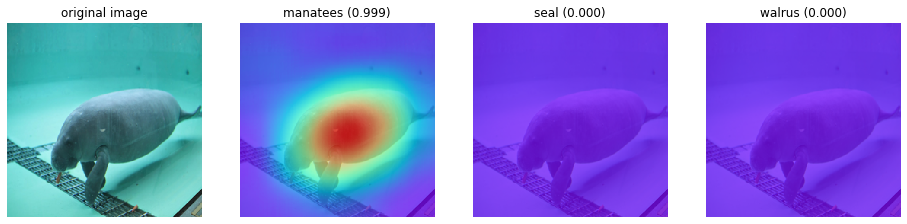

In [33]:
img = load_image('dataset/manatees/___ (3).jpg', size=input_size)
grad_cam.plot_image_heatmap(img, top=3, counterfactual=False, use_logits=True)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

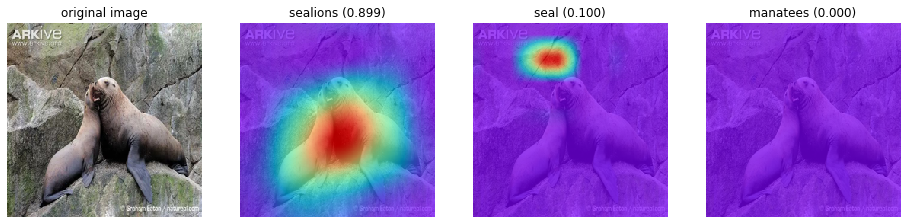

In [34]:
img = load_image('dataset/sealions/0.jpeg', size=input_size)
grad_cam.plot_image_heatmap(img, top=3, counterfactual=False, use_logits=True)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

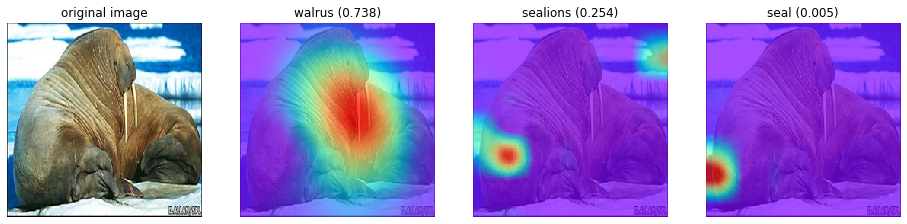

In [35]:
img = load_image('dataset/walrus/_42703347_spl_walrus_allan_416200.jpg', size=input_size)
grad_cam.plot_image_heatmap(img, top=3, counterfactual=False, use_logits=True)
plt.axis('off')

# Confusion Matrix

In [67]:
def confusionMatrix(model_path, mode):
    model = AnimalModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model = model.cuda()
    with torch.no_grad():
        dataset   = AnimalDataset(mode=mode)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True, 
                                pin_memory=True, num_workers=2*os.cpu_count())
        targets = torch.Tensor().type(torch.long)
        predicts = torch.Tensor().type(torch.long).cuda()
        for data in tqdm(dataloader, desc='Validation'):
            input, target = data[0].cuda(), data[1]
            targets = torch.cat((targets, target))
            output = model(input) 
            _, predicted = torch.max(output, 1)
            predicts = torch.cat((predicts, predicted))
        
        targets  = targets.numpy()
        predicts = predicts.cpu().numpy()
        c_matrix = confusion_matrix(targets, predicts, normalize='true',
                                    labels=[i for i in range(len(classes))])    
        return c_matrix
    
def format_func(value, tick_number):
    if (value >= 0) and (value <= 3):
        return classes[value.astype(np.int)]

Validation: 100%|██████████| 380/380 [00:03<00:00, 108.89it/s]


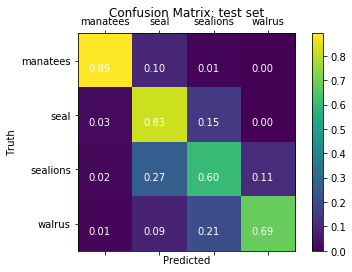

In [69]:
start_time = time.time()
mode = 'test'
path = 'model_save/17_best.pth'

c_matrix = confusionMatrix(model_path=path, mode=mode)
figure = plt.figure()
axes = figure.add_subplot(111)
axes.matshow(c_matrix)
axes.set_title(f'Confusion Matrix: {mode} set')
axes.set(xlabel = 'Predicted',ylabel = 'Truth')
axes.set_xticks(np.arange(0, len(classes)))
axes.set_yticks(np.arange(0, len(classes)))
caxes = axes.matshow(c_matrix, interpolation ='nearest') 
figure.colorbar(caxes)
axes.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
axes.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

for row_i, row in enumerate(c_matrix):
    for col_i, col in enumerate(row):
        axes.text(col_i-0.3,row_i+0.2,f'{col:.2f}',color='white')
plt.show()